In [1]:
## R code 5.1
# load data
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce

# standardize predictor
d$MedianAgeMarriage.s <- (d$MedianAgeMarriage-mean(d$MedianAgeMarriage))/
    sd(d$MedianAgeMarriage)

# fit model
m5.1 <- map(
    alist(
        Divorce ~ dnorm( mu , sigma ) ,
        mu <- a + bA * MedianAgeMarriage.s ,
        a ~ dnorm( 10 , 10 ) ,
        bA ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) , data = d )

Loading required package: rstan
Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.58)


In [2]:
## R code 5.2
# compute percentile interval of mean
MAM.seq <- seq( from=-3 , to=3.5 , length.out=30 )
mu <- link( m5.1 , data=data.frame(MedianAgeMarriage.s=MAM.seq) )
mu.PI <- apply( mu , 2 , PI )

# plot it all
plot( Divorce ~ MedianAgeMarriage.s , data=d , col=rangi2 )
abline( m5.1 )
shade( mu.PI , MAM.seq )

[ 1000 / 1000 ]


Warning message:
In abline(m5.1): only using the first two of 3 regression coefficients

In [3]:
## R code 5.3
d$Marriage.s <- (d$Marriage - mean(d$Marriage))/sd(d$Marriage)
m5.2 <- map(
    alist(
        Divorce ~ dnorm( mu , sigma ) ,
        mu <- a + bR * Marriage.s ,
        a ~ dnorm( 10 , 10 ) ,
        bR ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) , data = d )

In [4]:
## R code 5.4
m5.3 <- map(
    alist(
        Divorce ~ dnorm( mu , sigma ) ,
        mu <- a + bR*Marriage.s + bA*MedianAgeMarriage.s ,
        a ~ dnorm( 10 , 10 ) ,
        bR ~ dnorm( 0 , 1 ) ,
        bA ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data = d )
precis( m5.3 )

       Mean StdDev  5.5% 94.5%
a      9.69   0.20  9.36 10.01
bR    -0.13   0.28 -0.58  0.31
bA    -1.13   0.28 -1.58 -0.69
sigma  1.44   0.14  1.21  1.67

In [5]:
## R code 5.5
plot( precis(m5.3) )

In [6]:
## R code 5.6
m5.4 <- map(
    alist(
        Marriage.s ~ dnorm( mu , sigma ) ,
        mu <- a + b*MedianAgeMarriage.s ,
        a ~ dnorm( 0 , 10 ) ,
        b ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data = d )

In [7]:
## R code 5.7
# compute expected value at MAP, for each State
mu <- coef(m5.4)['a'] + coef(m5.4)['b']*d$MedianAgeMarriage.s
# compute residual for each State
m.resid <- d$Marriage.s - mu

In [8]:
## R code 5.8
plot( Marriage.s ~ MedianAgeMarriage.s , d , col=rangi2 )
abline( m5.4 )
# loop over States
for ( i in 1:length(m.resid) ) {
    x <- d$MedianAgeMarriage.s[i] # x location of line segment
    y <- d$Marriage.s[i] # observed endpoint of line segment
    # draw the line segment
    lines( c(x,x) , c(mu[i],y) , lwd=0.5 , col=col.alpha("black",0.7) )
}

Warning message:
In abline(m5.4): only using the first two of 3 regression coefficients

In [9]:
## R code 5.9
# prepare new counterfactual data
A.avg <- mean( d$MedianAgeMarriage.s )
R.seq <- seq( from=-3 , to=3 , length.out=30 )
pred.data <- data.frame(
    Marriage.s=R.seq,
    MedianAgeMarriage.s=A.avg
)

# compute counterfactual mean divorce (mu)
mu <- link( m5.3 , data=pred.data )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI )

# simulate counterfactual divorce outcomes
R.sim <- sim( m5.3 , data=pred.data , n=1e4 )
R.PI <- apply( R.sim , 2 , PI )

# display predictions, hiding raw data with type="n"
plot( Divorce ~ Marriage.s , data=d , type="n" )
mtext( "MedianAgeMarriage.s = 0" )
lines( R.seq , mu.mean )
shade( mu.PI , R.seq )
shade( R.PI , R.seq )

[ 1000 / 1000 ]
[ 10000 / 10000 ]


In [10]:
## R code 5.10
R.avg <- mean( d$Marriage.s )
A.seq <- seq( from=-3 , to=3.5 , length.out=30 )
pred.data2 <- data.frame(
    Marriage.s=R.avg,
    MedianAgeMarriage.s=A.seq
)

mu <- link( m5.3 , data=pred.data2 )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI )

A.sim <- sim( m5.3 , data=pred.data2 , n=1e4 )
A.PI <- apply( A.sim , 2 , PI )

plot( Divorce ~ MedianAgeMarriage.s , data=d , type="n" )
mtext( "Marriage.s = 0" )
lines( A.seq , mu.mean )
shade( mu.PI , A.seq )
shade( A.PI , A.seq )

[ 1000 / 1000 ]
[ 10000 / 10000 ]


In [11]:
## R code 5.11
# call link without specifying new data
# so it uses original data
mu <- link( m5.3 )

# summarize samples across cases
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI )

# simulate observations
# again no new data, so uses original data
divorce.sim <- sim( m5.3 , n=1e4 )
divorce.PI <- apply( divorce.sim , 2 , PI )

[ 1000 / 1000 ]
[ 10000 / 10000 ]


integer(0)

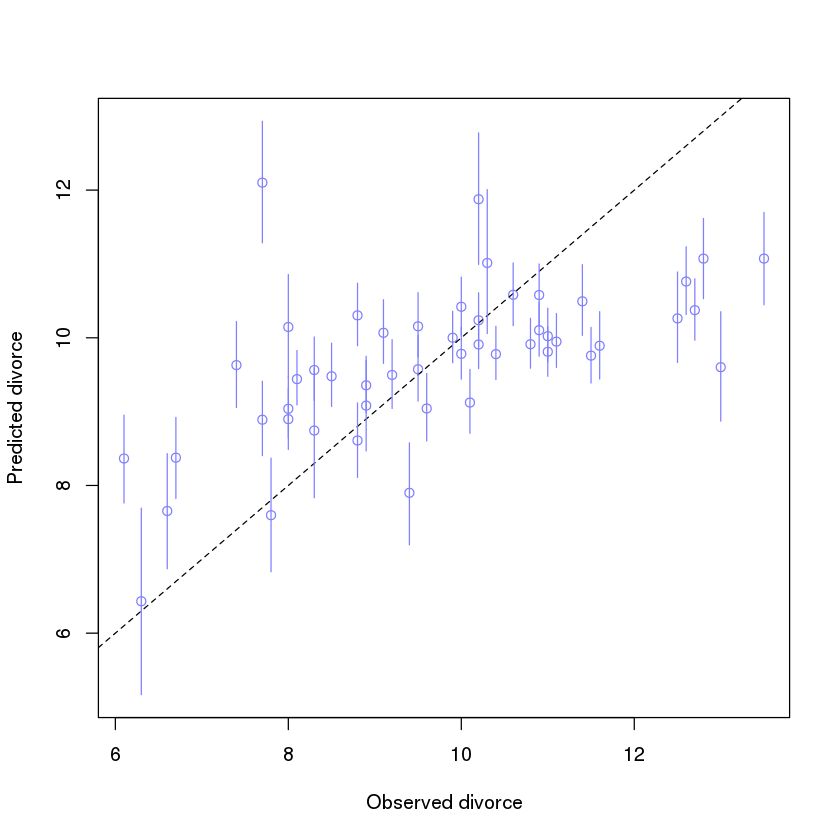

In [12]:
## R code 5.12
plot( mu.mean ~ d$Divorce , col=rangi2 , ylim=range(mu.PI) ,
    xlab="Observed divorce" , ylab="Predicted divorce" )
abline( a=0 , b=1 , lty=2 )
for ( i in 1:nrow(d) )
    lines( rep(d$Divorce[i],2) , c(mu.PI[1,i],mu.PI[2,i]) ,
        col=rangi2 )

## R code 5.13
identify( x=d$Divorce , y=mu.mean , labels=d$Loc , cex=0.8 )

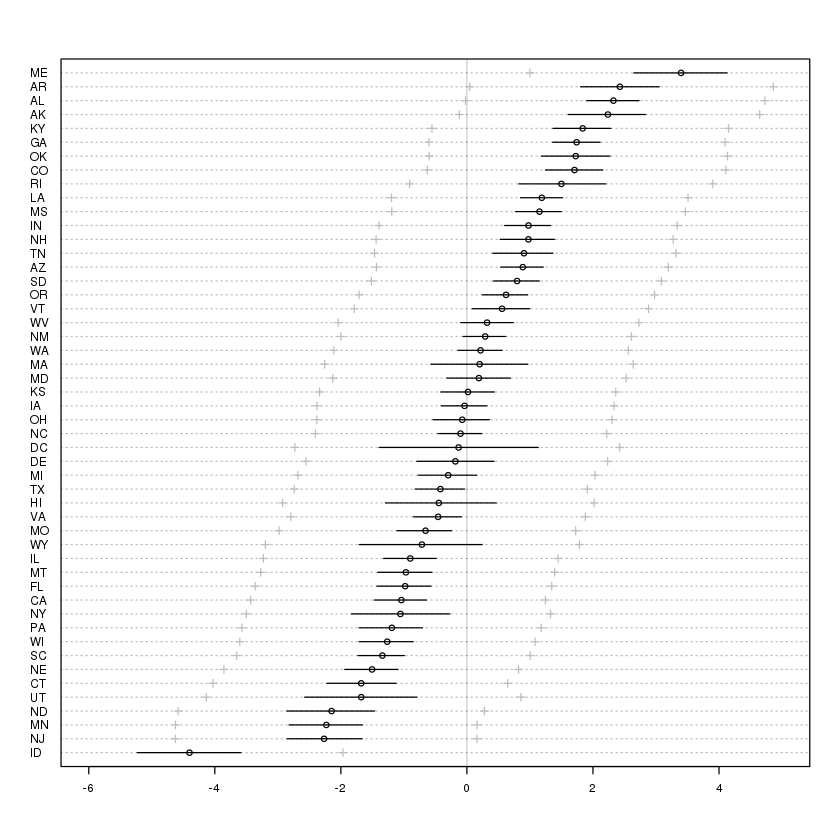

In [13]:
## R code 5.14
# compute residuals
divorce.resid <- d$Divorce - mu.mean
# get ordering by divorce rate
o <- order(divorce.resid)
# make the plot
dotchart( divorce.resid[o] , labels=d$Loc[o] , xlim=c(-6,5) , cex=0.6 )
abline( v=0 , col=col.alpha("black",0.2) )
for ( i in 1:nrow(d) ) {
    j <- o[i] # which State in order
    lines( d$Divorce[j]-c(mu.PI[1,j],mu.PI[2,j]) , rep(i,2) )
    points( d$Divorce[j]-c(divorce.PI[1,j],divorce.PI[2,j]) , rep(i,2),
        pch=3 , cex=0.6 , col="gray" )
}

In [14]:
## R code 5.15
N <- 100                         # number of cases
x_real <- rnorm( N )             # x_real as Gaussian with mean 0 and stddev 1
x_spur <- rnorm( N , x_real )    # x_spur as Gaussian with mean=x_real
y <- rnorm( N , x_real )         # y as Gaussian with mean=x_real
d <- data.frame(y,x_real,x_spur) # bind all together in data frame

In [15]:
## R code 5.16
library(rethinking)
data(milk)
d <- milk
str(d)

'data.frame':	29 obs. of  8 variables:
 $ clade         : Factor w/ 4 levels "Ape","New World Monkey",..: 4 4 4 4 4 2 2 2 2 2 ...
 $ species       : Factor w/ 29 levels "Alouatta seniculus",..: 11 8 9 10 16 1 2 6 27 28 ...
 $ kcal.per.g    : num  0.49 0.51 0.46 0.48 0.6 0.47 0.56 0.89 0.91 0.92 ...
 $ perc.fat      : num  16.6 19.3 14.1 14.9 27.3 ...
 $ perc.protein  : num  15.4 16.9 16.9 13.2 19.5 ...
 $ perc.lactose  : num  68 63.8 69 71.9 53.2 ...
 $ mass          : num  1.95 2.09 2.51 1.62 2.19 5.25 5.37 2.51 0.71 0.68 ...
 $ neocortex.perc: num  55.2 NA NA NA NA ...


In [16]:
## R code 5.17
m5.5 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bn*neocortex.perc ,
        a ~ dnorm( 0 , 100 ) ,
        bn ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 1 )
    ) ,
    data=d )

ERROR: Error in map(alist(kcal.per.g ~ dnorm(mu, sigma), mu <- a + bn * neocortex.perc, : initial value in 'vmmin' is not finite
The start values for the parameters were invalid. This could be caused by missing values (NA) in the data or by start values outside the parameter constraints. If there are no NA values in the data, try using explicit start values.


In [17]:
## R code 5.18
d$neocortex.perc

[1] 55.16    NA    NA    NA    NA 64.54 64.54 67.64    NA 68.85 58.85 61.69
[13] 60.32    NA    NA 69.97    NA 70.41    NA 73.40    NA 67.53    NA 71.26
[25] 72.60    NA 70.24 76.30 75.49

In [18]:
## R code 5.19
dcc <- d[ complete.cases(d) , ]

In [19]:
## R code 5.20
m5.5 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bn*neocortex.perc ,
        a ~ dnorm( 0 , 100 ) ,
        bn ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 1 )
    ) ,
    data=dcc )

In [20]:
## R code 5.21
precis( m5.5 , digits=3 )

       Mean StdDev   5.5% 94.5%
a     0.353  0.471 -0.399 1.106
bn    0.005  0.007 -0.007 0.016
sigma 0.166  0.028  0.120 0.211

In [21]:
## R code 5.22
coef(m5.5)["bn"] * ( 76 - 55 )

bn 
0.09456727

In [22]:
## R code 5.23
np.seq <- 0:100
pred.data <- data.frame( neocortex.perc=np.seq )

mu <- link( m5.5 , data=pred.data , n=1e4 )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI )

plot( kcal.per.g ~ neocortex.perc , data=dcc , col=rangi2 )
lines( np.seq , mu.mean )
lines( np.seq , mu.PI[1,] , lty=2 )
lines( np.seq , mu.PI[2,] , lty=2 )

[ 10000 / 10000 ]


In [23]:
## R code 5.24
dcc$log.mass <- log(dcc$mass)

In [24]:
## R code 5.25
m5.6 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bm*log.mass ,
        a ~ dnorm( 0 , 100 ) ,
        bm ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 1 )
    ) ,
    data=dcc )
precis(m5.6)

       Mean StdDev  5.5% 94.5%
a      0.71   0.05  0.63  0.78
bm    -0.03   0.02 -0.06  0.00
sigma  0.16   0.03  0.11  0.20

In [25]:
## R code 5.26
m5.7 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bn*neocortex.perc + bm*log.mass ,
        a ~ dnorm( 0 , 100 ) ,
        bn ~ dnorm( 0 , 1 ) ,
        bm ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 1 )
    ) ,
    data=dcc )
precis(m5.7)

       Mean StdDev  5.5% 94.5%
a     -1.08   0.47 -1.83 -0.34
bn     0.03   0.01  0.02  0.04
bm    -0.10   0.02 -0.13 -0.06
sigma  0.11   0.02  0.08  0.15

In [26]:
## R code 5.27
mean.log.mass <- mean( log(dcc$mass) )
np.seq <- 0:100
pred.data <- data.frame(
    neocortex.perc=np.seq,
    log.mass=mean.log.mass
)

mu <- link( m5.7 , data=pred.data , n=1e4 )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI )

plot( kcal.per.g ~ neocortex.perc , data=dcc , type="n" )
lines( np.seq , mu.mean )
lines( np.seq , mu.PI[1,] , lty=2 )
lines( np.seq , mu.PI[2,] , lty=2 )

[ 10000 / 10000 ]


In [27]:
## R code 5.28
N <- 100                         # number of cases
rho <- 0.7                       # correlation btw x_pos and x_neg
x_pos <- rnorm( N )              # x_pos as Gaussian
x_neg <- rnorm( N , rho*x_pos ,  # x_neg correlated with x_pos
    sqrt(1-rho^2) )
y <- rnorm( N , x_pos - x_neg )  # y equally associated with x_pos, x_neg
d <- data.frame(y,x_pos,x_neg)   # bind all together in data frame

In [28]:
## R code 5.29
N <- 100                          # number of individuals
height <- rnorm(N,10,2)           # sim total height of each
leg_prop <- runif(N,0.4,0.5)      # leg as proportion of height
leg_left <- leg_prop*height +     # sim left leg as proportion + error
    rnorm( N , 0 , 0.02 )
leg_right <- leg_prop*height +    # sim right leg as proportion + error
    rnorm( N , 0 , 0.02 )
                                  # combine into data frame
d <- data.frame(height,leg_left,leg_right)

In [29]:
## R code 5.30
m5.8 <- map(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + bl*leg_left + br*leg_right ,
        a ~ dnorm( 10 , 100 ) ,
        bl ~ dnorm( 2 , 10 ) ,
        br ~ dnorm( 2 , 10 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )
precis(m5.8)

       Mean StdDev  5.5% 94.5%
a      1.03   0.32  0.52  1.53
bl     3.66   2.16  0.21  7.12
br    -1.66   2.16 -5.11  1.78
sigma  0.61   0.04  0.54  0.68

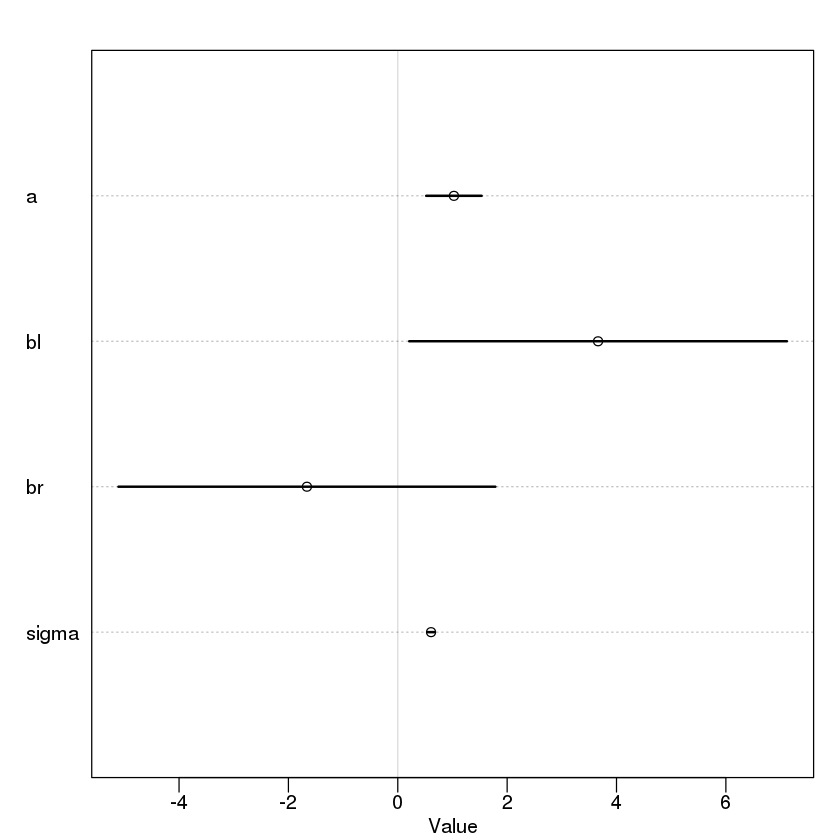

In [30]:
## R code 5.31
plot(precis(m5.8))

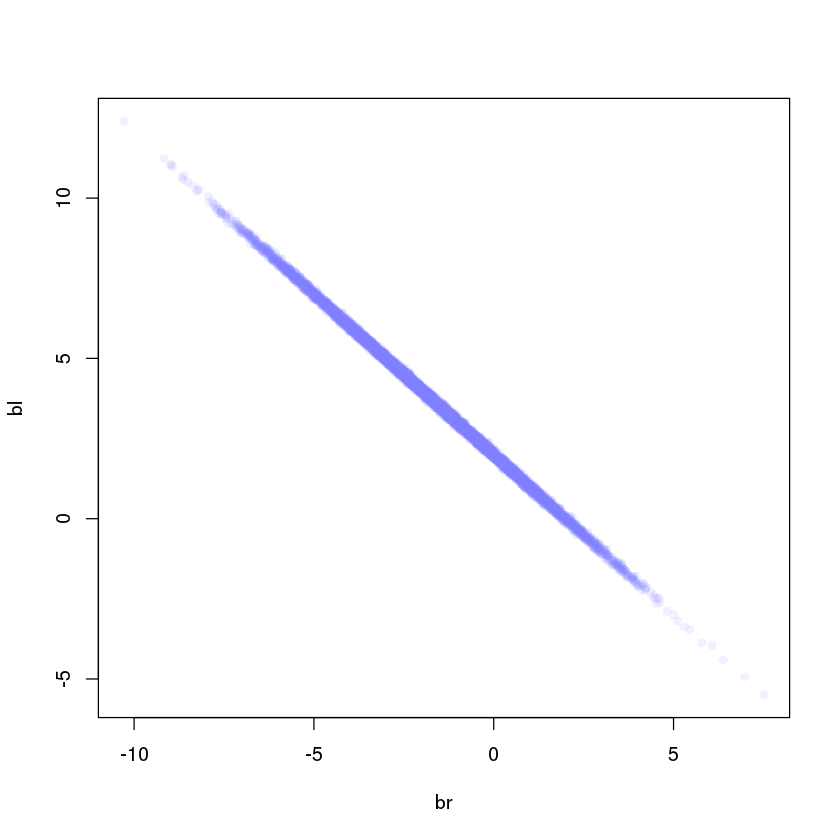

In [31]:
## R code 5.32
post <- extract.samples(m5.8)
plot( bl ~ br , post , col=col.alpha(rangi2,0.1) , pch=16 )

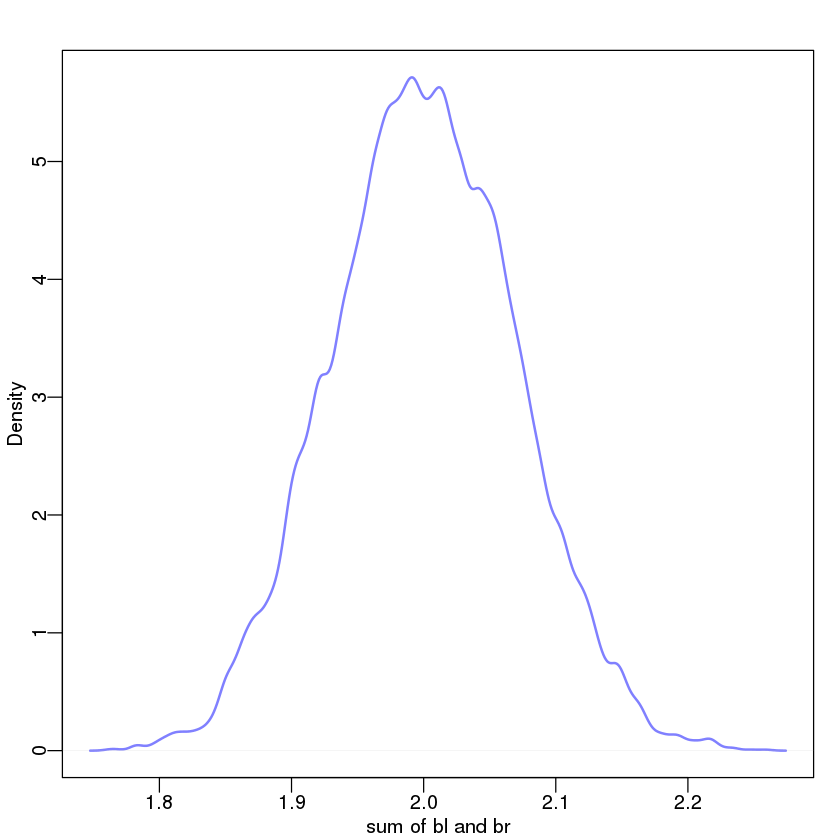

In [32]:
## R code 5.33
sum_blbr <- post$bl + post$br
dens( sum_blbr , col=rangi2 , lwd=2 , xlab="sum of bl and br" )

In [33]:
## R code 5.34
m5.9 <- map(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + bl*leg_left,
        a ~ dnorm( 10 , 100 ) ,
        bl ~ dnorm( 2 , 10 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )
precis(m5.9)

      Mean StdDev 5.5% 94.5%
a     1.03   0.32 0.52  1.54
bl    2.00   0.07 1.89  2.11
sigma 0.61   0.04 0.54  0.68

In [34]:
## R code 5.35
library(rethinking)
data(milk)
d <- milk

In [35]:
## R code 5.36
# kcal.per.g regressed on perc.fat
m5.10 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bf*perc.fat ,
        a ~ dnorm( 0.6 , 10 ) ,
        bf ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )

# kcal.per.g regressed on perc.lactose
m5.11 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bl*perc.lactose ,
        a ~ dnorm( 0.6 , 10 ) ,
        bl ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )

precis( m5.10 , digits=3 )
precis( m5.11 , digits=3 )

       Mean StdDev  5.5% 94.5%
a     0.301  0.036 0.244 0.358
bf    0.010  0.001 0.008 0.012
sigma 0.073  0.010 0.058 0.089

        Mean StdDev   5.5%  94.5%
a      1.166  0.043  1.098  1.235
bl    -0.011  0.001 -0.012 -0.009
sigma  0.062  0.008  0.049  0.075

In [36]:
## R code 5.37
m5.12 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + bf*perc.fat + bl*perc.lactose ,
        a ~ dnorm( 0.6 , 10 ) ,
        bf ~ dnorm( 0 , 1 ) ,
        bl ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )
precis( m5.12 , digits=3 )

        Mean StdDev   5.5%  94.5%
a      1.007  0.200  0.688  1.327
bf     0.002  0.002 -0.002  0.006
bl    -0.009  0.002 -0.013 -0.005
sigma  0.061  0.008  0.048  0.074

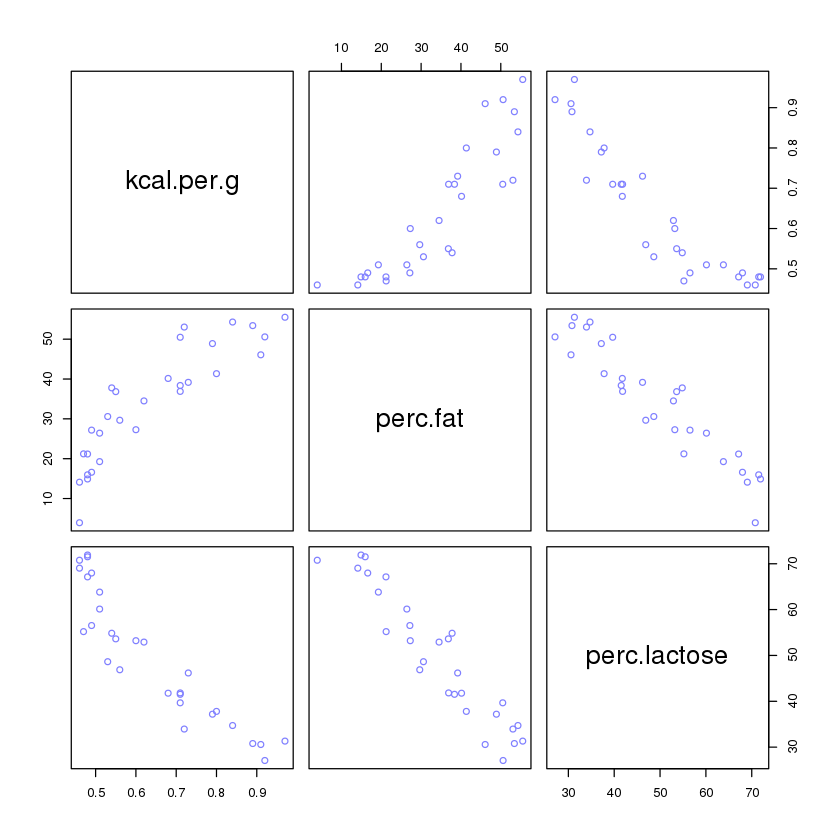

In [37]:
## R code 5.38
pairs( ~ kcal.per.g + perc.fat + perc.lactose ,
    data=d , col=rangi2 )

In [38]:
## R code 5.39
cor( d$perc.fat , d$perc.lactose )

[1] -0.9416373

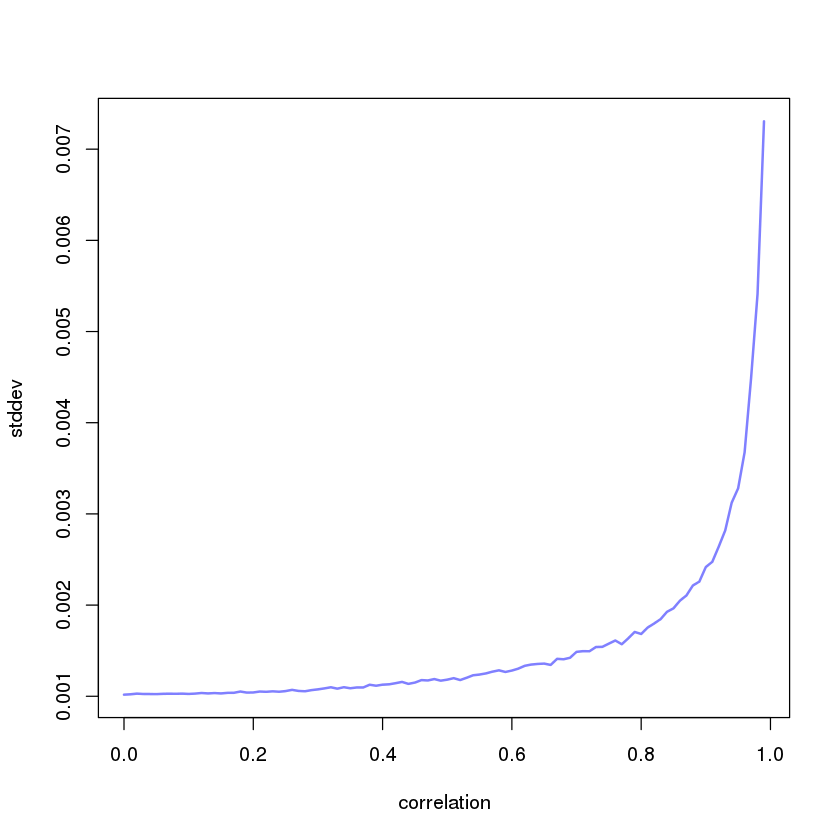

In [39]:
## R code 5.40
library(rethinking)
data(milk)
d <- milk
sim.coll <- function( r=0.9 ) {
    d$x <- rnorm( nrow(d) , mean=r*d$perc.fat ,
        sd=sqrt( (1-r^2)*var(d$perc.fat) ) )
    m <- lm( kcal.per.g ~ perc.fat + x , data=d )
    sqrt( diag( vcov(m) ) )[2] # stddev of parameter
}
rep.sim.coll <- function( r=0.9 , n=100 ) {
    stddev <- replicate( n , sim.coll(r) )
    mean(stddev)
}
r.seq <- seq(from=0,to=0.99,by=0.01)
stddev <- sapply( r.seq , function(z) rep.sim.coll(r=z,n=100) )
plot( stddev ~ r.seq , type="l" , col=rangi2, lwd=2 , xlab="correlation" )

In [40]:
## R code 5.41
# number of plants
N <- 100

# simulate initial heights
h0 <- rnorm(N,10,2)

# assign treatments and simulate fungus and growth
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 )
h1 <- h0 + rnorm(N, 5 - 3*fungus)

# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus )

In [41]:
## R code 5.42
m5.13 <- map(
    alist(
        h1 ~ dnorm(mu,sigma),
        mu <- a + bh*h0 + bt*treatment + bf*fungus,
        a ~ dnorm(0,100),
        c(bh,bt,bf) ~ dnorm(0,10),
        sigma ~ dunif(0,10)
    ),
    data=d )
precis(m5.13)

       Mean StdDev  5.5% 94.5%
a      5.19   0.51  4.38  6.00
bh     1.00   0.05  0.92  1.08
bt    -0.37   0.19 -0.68 -0.06
bf    -3.05   0.22 -3.40 -2.70
sigma  0.90   0.06  0.80  1.00

In [42]:
## R code 5.43
m5.14 <- map(
    alist(
        h1 ~ dnorm(mu,sigma),
        mu <- a + bh*h0 + bt*treatment,
        a ~ dnorm(0,100),
        c(bh,bt) ~ dnorm(0,10),
        sigma ~ dunif(0,10)
    ),
    data=d )
precis(m5.14)

      Mean StdDev 5.5% 94.5%
a     4.41   0.86 3.03  5.79
bh    0.95   0.08 0.81  1.08
bt    0.60   0.31 0.11  1.09
sigma 1.53   0.11 1.36  1.71

In [43]:
## R code 5.44
data(Howell1)
d <- Howell1
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


In [44]:
## R code 5.45
m5.15 <- map(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + bm*male ,
        a ~ dnorm( 178 , 100 ) ,
        bm ~ dnorm( 0 , 10 ) ,
        sigma ~ dunif( 0 , 50 )
    ) ,
    data=d )
precis(m5.15)

        Mean StdDev   5.5%  94.5%
a     134.82   1.59 132.28 137.36
bm      7.30   2.28   3.65  10.95
sigma  27.31   0.83  25.99  28.63

In [45]:
## R code 5.46
post <- extract.samples(m5.15)
mu.male <- post$a + post$bm
PI(mu.male)

5%      94% 
139.4235 144.8160

In [46]:
## R code 5.47
m5.15b <- map(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- af*(1-male) + am*male ,
        af ~ dnorm( 178 , 100 ) ,
        am ~ dnorm( 178 , 100 ) ,
        sigma ~ dunif( 0 , 50 )
    ) ,
    data=d )

In [47]:
## R code 5.48
data(milk)
d <- milk
unique(d$clade)

[1] Strepsirrhine    New World Monkey Old World Monkey Ape             
Levels: Ape New World Monkey Old World Monkey Strepsirrhine

In [48]:
## R code 5.49
( d$clade.NWM <- ifelse( d$clade=="New World Monkey" , 1 , 0 ) )

[1] 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [49]:
## R code 5.50
d$clade.OWM <- ifelse( d$clade=="Old World Monkey" , 1 , 0 )
d$clade.S <- ifelse( d$clade=="Strepsirrhine" , 1 , 0 )

In [50]:
## R code 5.51
m5.16 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a + b.NWM*clade.NWM + b.OWM*clade.OWM + b.S*clade.S ,
        a ~ dnorm( 0.6 , 10 ) ,
        b.NWM ~ dnorm( 0 , 1 ) ,
        b.OWM ~ dnorm( 0 , 1 ) ,
        b.S ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )
precis(m5.16)

       Mean StdDev  5.5% 94.5%
a      0.55   0.04  0.49  0.61
b.NWM  0.17   0.05  0.08  0.25
b.OWM  0.24   0.06  0.15  0.34
b.S   -0.04   0.06 -0.14  0.06
sigma  0.11   0.02  0.09  0.14

In [51]:
## R code 5.52
# sample posterior
post <- extract.samples(m5.16)

In [52]:
# compute averages for each category
mu.ape <- post$a
mu.NWM <- post$a + post$b.NWM
mu.OWM <- post$a + post$b.OWM
mu.S <- post$a + post$b.S

# summarize using precis
precis( data.frame(mu.ape,mu.NWM,mu.OWM,mu.S) )

       Mean StdDev |0.89 0.89|
mu.ape 0.55   0.04  0.49  0.61
mu.NWM 0.71   0.04  0.65  0.77
mu.OWM 0.79   0.05  0.71  0.86
mu.S   0.51   0.05  0.42  0.59

In [53]:
## R code 5.53
diff.NWM.OWM <- mu.NWM - mu.OWM
quantile( diff.NWM.OWM , probs=c(0.025,0.5,0.975) )

2.5%         50%       97.5% 
-0.18900273 -0.07324429  0.04609004

In [54]:
## R code 5.54
( d$clade_id <- coerce_index(d$clade) )

[1] 4 4 4 4 4 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1

In [55]:
## R code 5.55
m5.16_alt <- map(
    alist(
        kcal.per.g ~ dnorm( mu , sigma ) ,
        mu <- a[clade_id] ,
        a[clade_id] ~ dnorm( 0.6 , 10 ) ,
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=d )
precis( m5.16_alt , depth=2 )

      Mean StdDev 5.5% 94.5%
a[1]  0.55   0.04 0.48  0.61
a[2]  0.71   0.04 0.65  0.78
a[3]  0.79   0.05 0.71  0.86
a[4]  0.51   0.05 0.43  0.59
sigma 0.11   0.02 0.09  0.14

In [56]:
## R code 5.56
m5.17 <- lm( y ~ 1 + x , data=d )
m5.18 <- lm( y ~ 1 + x + z + w , data=d )

ERROR: Error in model.frame.default(formula = y ~ 1 + x, data = d, drop.unused.levels = TRUE): variable lengths differ (found for 'x')


ERROR: Error in eval(expr, envir, enclos): object 'z' not found


In [57]:
## R code 5.57
m5.17 <- lm( y ~ 1 + x , data=d )
m5.19 <- lm( y ~ x , data=d )

ERROR: Error in model.frame.default(formula = y ~ 1 + x, data = d, drop.unused.levels = TRUE): variable lengths differ (found for 'x')


ERROR: Error in model.frame.default(formula = y ~ x, data = d, drop.unused.levels = TRUE): variable lengths differ (found for 'x')


In [58]:
## R code 5.58
m5.20 <- lm( y ~ 0 + x , data=d )
m5.21 <- lm( y ~ x - 1 , data=d )

ERROR: Error in model.frame.default(formula = y ~ 0 + x, data = d, drop.unused.levels = TRUE): variable lengths differ (found for 'x')


ERROR: Error in model.frame.default(formula = y ~ x - 1, data = d, drop.unused.levels = TRUE): variable lengths differ (found for 'x')


In [59]:
## R code 5.59
m5.22 <- lm( y ~ 1 + as.factor(season) , data=d )

ERROR: Error in is.factor(x): object 'season' not found


In [60]:
## R code 5.60
d$x2 <- d$x^2
d$x3 <- d$x^3
m5.23 <- lm( y ~ 1 + x + x2 + x3 , data=d )

ERROR: Error in `$<-.data.frame`(`*tmp*`, "x2", value = numeric(0)): replacement has 0 rows, data has 29


ERROR: Error in `$<-.data.frame`(`*tmp*`, "x3", value = numeric(0)): replacement has 0 rows, data has 29


ERROR: Error in eval(expr, envir, enclos): object 'x2' not found


In [61]:
## R code 5.61
m5.24 <- lm( y ~ 1 + x + I(x^2) + I(x^3) , data=d )

ERROR: Error in model.frame.default(formula = y ~ 1 + x + I(x^2) + I(x^3), data = d, : variable lengths differ (found for 'x')


In [62]:
## R code 5.62
data(cars)
glimmer( dist ~ speed , data=cars )

alist(
    dist ~ dnorm( mu , sigma ),
    mu <- Intercept +
        b_speed*speed,
    Intercept ~ dnorm(0,10),
    b_speed ~ dnorm(0,10),
    sigma ~ dcauchy(0,2)
)
